# 03 · Synthetic Log Inference Pipeline

This notebook assembles a clean, end-to-end pipeline that fabricates synthetic OpenStack control-plane logs, scores them with the fine-tuned LogBERT (DistilBERT) model, and reports anomaly-detection quality metrics.

## Pipeline Overview

- Generate a balanced mix of OpenStack service logs (nova, neutron, cinder, keystone, glance) with a controllable anomaly ratio
- Tokenize the logs and score them with the masked language model to obtain anomaly scores
- Sweep candidate thresholds, pick the best according to F1, and compare with the trained threshold when available
- Persist predictions, metrics, and visual diagnostics for downstream inspection

In [1]:
import json
import random
import re
from dataclasses import dataclass
from datetime import datetime, timedelta
from pathlib import Path
from typing import Dict, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import yaml
from IPython.display import display
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from transformers import AutoModelForMaskedLM, AutoTokenizer

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"✅ Environment ready. Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

/home/tpi/anaconda3/envs/log_anomaly/lib/python3.11/site-packages/torch/cuda/__init__.py:54: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


✅ Environment ready. Device available: CUDA


## Load Model and Configuration

In [2]:
def load_yaml(path: Path) -> Dict:
    with path.open("r") as fh:
        return yaml.safe_load(fh)

CONFIG_DIR = Path("../configs")
train_cfg = load_yaml(CONFIG_DIR / "train_openstack.yaml")

# Load tokenizer
tokenizer_dir = Path(train_cfg["artifacts"]["tokenizer_dir"])
if not tokenizer_dir.exists():
    raise FileNotFoundError(
        f"Tokenizer directory not found: {tokenizer_dir}. Run the fine-tuning notebook before inference."
    )

tokenizer = AutoTokenizer.from_pretrained(tokenizer_dir, use_fast=True)

# Load model checkpoint
checkpoint_root = Path(train_cfg["checkpointing"]["output_dir"])
best_dir = checkpoint_root / "best"
if best_dir.exists():
    model_dir = best_dir
else:
    epoch_dirs = sorted(checkpoint_root.glob("epoch*_final"))
    if not epoch_dirs:
        raise FileNotFoundError(
            f"No trained checkpoints found under {checkpoint_root}. Run the fine-tuning notebook before inference."
        )
    model_dir = epoch_dirs[-1]

model = AutoModelForMaskedLM.from_pretrained(model_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Retrieve trained threshold if available
metrics_dir = Path(train_cfg["artifacts"]["metrics_dir"])
metrics_file = metrics_dir / "openstack_metrics.json"
trained_threshold: Optional[float] = None
if metrics_file.exists():
    with metrics_file.open("r") as fh:
        stored_metrics = json.load(fh)
    trained_threshold = float(stored_metrics.get("val_threshold_loss", 5.0))
    print(f"📊 Loaded stored anomaly threshold: {trained_threshold:.4f}")
else:
    print("⚠️ No stored anomaly threshold found — the pipeline will derive an optimal threshold from synthetic data.")

MAX_LENGTH = int(train_cfg["sequence"]["max_length"])
print(f"🔍 Tokenizer loaded from {tokenizer_dir}")
print(f"🧠 Using model checkpoint: {model_dir}")
print(f"📏 Max sequence length: {MAX_LENGTH}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


📊 Loaded stored anomaly threshold: 0.6608
🔍 Tokenizer loaded from artifacts/tokenizer
🧠 Using model checkpoint: artifacts/logbert-mlm-os/best
📏 Max sequence length: 256


## Synthetic Log Generator

In [5]:
class OpenStackLogGenerator:
    """Generate synthetic OpenStack service logs with controllable anomalies."""

    def __init__(self, seed: int = 42) -> None:
        self.rng = random.Random(seed)
        self.services = ["nova", "neutron", "cinder", "keystone", "glance"]
        self.normal_levels = ["INFO", "DEBUG", "AUDIT"]
        self.alert_levels = ["WARNING", "ERROR", "CRITICAL"]
        self.request_sources = ["api", "scheduler", "rpc", "conductor", "compute"]
        self.tenants = [f"tenant-{i:03d}" for i in range(1, 250)]
        self.users = [f"user{i:04d}" for i in range(1, 2000)]
        self.hosts = [f"node{i:02d}.control.local" for i in range(1, 40)]
        self.image_ids = [f"{self.rng.randrange(1, 9999):08x}" for _ in range(50)]
        self.volume_ids = [f"vol-{self.rng.randrange(10000, 99999)}" for _ in range(50)]
        self.networks = [f"net-{self.rng.randrange(10000, 99999)}" for _ in range(40)]

    def _timestamp(self) -> str:
        base_time = datetime.now()
        offset = timedelta(
            days=self.rng.randint(0, 3),
            hours=self.rng.randint(0, 23),
            minutes=self.rng.randint(0, 59),
            seconds=self.rng.randint(0, 59),
            microseconds=self.rng.randint(0, 999999),
        )
        return (base_time - offset).strftime("%Y-%m-%d %H:%M:%S.%f")

    def _pid(self) -> int:
        return self.rng.randint(1000, 99999)

    def _req_id(self) -> str:
        return f"req-{self.rng.getrandbits(32):08x}"

    def _ip(self) -> str:
        return f"10.{self.rng.randint(0, 255)}.{self.rng.randint(0, 255)}.{self.rng.randint(1, 254)}"

    def _normal_event(self, service: str, source: str, host: str, tenant: str) -> str:
        user = self.rng.choice(self.users)
        if service == "nova":
            messages = [
                f"Starting instance boot sequence on compute {host}",
                f"Finished scheduling instance for {tenant} on {host}",
                "Updating instance power state from SHUTOFF to RUNNING",
                f"Processing heartbeat from compute {host}",
            ]
        elif service == "neutron":
            messages = [
                f"Provisioned port on network {self.rng.choice(self.networks)} for {tenant}",
                f"Updated security group rules for {tenant}",
                f"Handled DHCP request from {self._ip()} via {source}",
                f"Applied router interface update on {host}",
            ]
        elif service == "cinder":
            messages = [
                f"Created volume {self.rng.choice(self.volume_ids)} size {self.rng.randint(10, 200)}G",
                f"Completed snapshot for volume {self.rng.choice(self.volume_ids)}",
                f"Attachment request for volume {self.rng.choice(self.volume_ids)} on {host}",
                "Volume stats update completed",
            ]
        elif service == "keystone":
            messages = [
                f"Authentication successful for {user}",
                f"Issued token for project {tenant}",
                f"Validated trust for service account {user}",
                "Rotated Fernet token keys",
            ]
        else:
            messages = [
                f"Uploaded image {self.rng.choice(self.image_ids)} to backend store",
                f"Image cache refreshed on {host}",
                f"Processing image download request for {tenant}",
                "Glance registry heartbeat sent",
            ]
        return f"{tenant} {user} {service}.{source}: {self.rng.choice(messages)}"

    def _anomaly_event(self, service: str, host: str, tenant: str) -> str:
        user = self.rng.choice(self.users)
        if service == "nova":
            messages = [
                f"Compute host {host} reported instance BUILD->ERROR: No valid host found",
                f"Live migration failed: timeout waiting for libvirt on {host}",
                f"RPC timeout while talking to conductor on {host}",
                "Failed to create instance snapshot: qemu-img exited with status 1",
            ]
        elif service == "neutron":
            messages = [
                f"L3 agent on {host} lost connection to metadata service",
                f"IP allocation exhausted on network {self.rng.choice(self.networks)}",
                f"Security group rule conflict detected for {tenant}",
                f"VXLAN tunnel endpoint {self._ip()} unreachable",
            ]
        elif service == "cinder":
            messages = [
                f"Volume {self.rng.choice(self.volume_ids)} stuck in 'in-use' after detach",
                f"Backend storage timeout creating volume {self.rng.choice(self.volume_ids)}",
                "Replication failure: driver reported InvalidIOError",
                f"Quota exceeded for tenant {tenant} on gigabytes",
            ]
        elif service == "keystone":
            messages = [
                f"Authentication failure for {user}: account locked",
                "Token validation error: signature revoked",
                "Unexpected 503 from identity backend",
                f"Rate limit exceeded for IP {self._ip()}",
            ]
        else:
            messages = [
                f"Image import failed checksum verification for {self.rng.choice(self.image_ids)}",
                "Glance API returned 500: swift proxy timeout",
                f"Image cache corruption detected on {host}",
                "Registry connection pool exhausted",
            ]
        return f"{tenant} {user} {service}.error: {self.rng.choice(messages)}"

    def generate(self, total_logs: int = 50000, anomaly_ratio: float = 0.15) -> pd.DataFrame:
        if not 0 < anomaly_ratio < 1:
            raise ValueError("anomaly_ratio must be between 0 and 1")

        total_anomalies = int(total_logs * anomaly_ratio)
        labels = [1] * total_anomalies + [0] * (total_logs - total_anomalies)
        self.rng.shuffle(labels)

        records = []
        for label in labels:
            service = self.rng.choice(self.services)
            source = self.rng.choice(self.request_sources)
            host = self.rng.choice(self.hosts)
            tenant = self.rng.choice(self.tenants)
            timestamp = self._timestamp()
            level = self.rng.choice(self.alert_levels if label else self.normal_levels)
            pid = self._pid()
            req = self._req_id()
            message = (
                self._anomaly_event(service, host, tenant)
                if label
                else self._normal_event(service, source, host, tenant)
            )
            process = f"{service}.{source}" if not label else f"{service}.error"
            content = f"{timestamp} {pid} {level} {service.upper()} {process} [req:{req}] {message}"
            records.append(
                {
                    "timestamp": timestamp,
                    "log_type": service,
                    "severity": level,
                    "content": content,
                    "anomaly_label": label,
                }
            )

        return pd.DataFrame.from_records(records)


## Pipeline Implementation

In [6]:
@dataclass
class PipelineResult:
    enriched_logs: pd.DataFrame
    losses: np.ndarray
    predictions: np.ndarray
    best_threshold: float
    threshold_curve: pd.DataFrame
    threshold_metrics: pd.DataFrame
    confusion_matrix: np.ndarray
    global_metrics: Dict[str, float]


class SyntheticLogInferencePipeline:
    """Orchestrates tokenization, scoring, threshold tuning, and reporting."""

    def __init__(
        self,
        model: AutoModelForMaskedLM,
        tokenizer: AutoTokenizer,
        device: torch.device,
        max_length: int,
        trained_threshold: Optional[float] = None,
    ) -> None:
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.max_length = max_length
        self.trained_threshold = trained_threshold

        if tokenizer.mask_token_id is None:
            raise ValueError("Tokenizer must expose a mask_token_id for MLM scoring.")
        self.mask_token_id = tokenizer.mask_token_id
        self.special_token_ids = {
            token_id
            for token_id in [tokenizer.pad_token_id, tokenizer.cls_token_id, tokenizer.sep_token_id]
            if token_id is not None
        }

    def _compute_losses(
        self,
        encoded_batch: Dict[str, torch.Tensor],
        batch_size: int = 16,
        mask_probability: float = 0.15,
    ) -> np.ndarray:
        input_ids = encoded_batch["input_ids"]
        attention_mask = encoded_batch["attention_mask"]
        dataset_size = input_ids.size(0)

        loss_fct = torch.nn.CrossEntropyLoss(reduction="none", ignore_index=-100)
        losses: list[float] = []

        for start in range(0, dataset_size, batch_size):
            end = start + batch_size
            batch_input = input_ids[start:end].to(self.device)
            batch_attention = attention_mask[start:end].to(self.device)

            labels = batch_input.clone()
            masked_input = batch_input.clone()

            rand = torch.rand_like(masked_input, dtype=torch.float32)
            maskable = torch.ones_like(masked_input, dtype=torch.bool)
            for token_id in self.special_token_ids:
                maskable &= masked_input != token_id
            mask_positions = (rand < mask_probability) & maskable

            masked_input[mask_positions] = self.mask_token_id
            labels[~mask_positions] = -100

            outputs = self.model(input_ids=masked_input, attention_mask=batch_attention, labels=labels)
            logits = outputs.logits

            token_loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
            token_loss = token_loss.view(masked_input.size(0), -1)
            valid_mask = labels != -100
            valid_counts = valid_mask.sum(dim=1).clamp(min=1)
            summed_loss = (token_loss * valid_mask).sum(dim=1)
            zeros = torch.zeros_like(summed_loss)
            batch_losses = torch.where(valid_mask.sum(dim=1) > 0, summed_loss / valid_counts, zeros)

            losses.extend(batch_losses.detach().cpu().numpy().tolist())

        return np.array(losses)

    def _sweep_thresholds(
        self, losses: np.ndarray, true_labels: np.ndarray, metric: str = "f1"
    ) -> tuple[float, pd.DataFrame]:
        percentiles = np.linspace(60, 99.5, 80)
        candidate_thresholds = np.unique(np.percentile(losses, percentiles))

        records = []
        best_threshold = float(candidate_thresholds[0])
        best_score = -np.inf

        for threshold in candidate_thresholds:
            preds = (losses >= threshold).astype(int)
            record = {
                "threshold": float(threshold),
                "precision": precision_score(true_labels, preds, zero_division=0),
                "recall": recall_score(true_labels, preds, zero_division=0),
                "f1": f1_score(true_labels, preds, zero_division=0),
                "accuracy": accuracy_score(true_labels, preds),
            }
            records.append(record)
            if record[metric] > best_score:
                best_score = record[metric]
                best_threshold = float(threshold)

        threshold_curve = pd.DataFrame(records).sort_values("threshold").reset_index(drop=True)
        return best_threshold, threshold_curve

    def _collect_threshold_metrics(
        self,
        true_labels: np.ndarray,
        predictions: np.ndarray,
        threshold: float,
        label: str,
    ) -> tuple[Dict[str, float], np.ndarray]:
        cm = confusion_matrix(true_labels, predictions)
        tn, fp, fn, tp = cm.ravel()
        metrics = {
            "label": label,
            "threshold": float(threshold),
            "accuracy": accuracy_score(true_labels, predictions),
            "precision": precision_score(true_labels, predictions, zero_division=0),
            "recall": recall_score(true_labels, predictions, zero_division=0),
            "f1": f1_score(true_labels, predictions, zero_division=0),
            "predicted_anomalies": int(predictions.sum()),
            "true_anomalies": int(true_labels.sum()),
            "support": int(len(true_labels)),
            "tn": int(tn),
            "fp": int(fp),
            "fn": int(fn),
            "tp": int(tp),
        }
        return metrics, cm

    def run(
        self,
        logs_df: pd.DataFrame,
        batch_size: int = 16,
        mask_probability: float = 0.15,
        metric: str = "f1",
    ) -> PipelineResult:
        encoded = self.tokenizer(
            logs_df["content"].tolist(),
            padding=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        losses = self._compute_losses(encoded, batch_size=batch_size, mask_probability=mask_probability)
        true_labels = logs_df["anomaly_label"].to_numpy()

        best_threshold, threshold_curve = self._sweep_thresholds(losses, true_labels, metric=metric)
        best_predictions = (losses >= best_threshold).astype(int)
        optimal_metrics, cm_optimal = self._collect_threshold_metrics(
            true_labels, best_predictions, best_threshold, label="optimal"
        )

        threshold_rows = [optimal_metrics]
        if self.trained_threshold is not None:
            trained_predictions = (losses >= self.trained_threshold).astype(int)
            trained_metrics, _ = self._collect_threshold_metrics(
                true_labels, trained_predictions, self.trained_threshold, label="trained"
            )
            threshold_rows.append(trained_metrics)

        threshold_metrics = pd.DataFrame(threshold_rows)
        enriched_logs = logs_df.copy()
        enriched_logs["mlm_loss"] = losses
        enriched_logs["prediction"] = best_predictions

        roc_auc = roc_auc_score(true_labels, losses)
        pr_auc = average_precision_score(true_labels, losses)
        global_metrics = {
            "roc_auc": float(roc_auc),
            "average_precision": float(pr_auc),
            "loss_mean": float(losses.mean()),
            "loss_std": float(losses.std()),
        }

        return PipelineResult(
            enriched_logs=enriched_logs,
            losses=losses,
            predictions=best_predictions,
            best_threshold=best_threshold,
            threshold_curve=threshold_curve,
            threshold_metrics=threshold_metrics,
            confusion_matrix=cm_optimal,
            global_metrics=global_metrics,
        )

    def save_artifacts(self, result: PipelineResult, artifact_dir: Path) -> Dict[str, Path]:
        artifact_dir.mkdir(parents=True, exist_ok=True)

        predictions_path = artifact_dir / "synthetic_predictions.csv"
        result.enriched_logs.to_csv(predictions_path, index=False)

        threshold_metrics_path = artifact_dir / "threshold_metrics.csv"
        result.threshold_metrics.to_csv(threshold_metrics_path, index=False)

        threshold_sweep_path = artifact_dir / "threshold_sweep.csv"
        result.threshold_curve.to_csv(threshold_sweep_path, index=False)

        metrics_payload = {
            "best_threshold": float(result.best_threshold),
            "global_metrics": {k: float(v) for k, v in result.global_metrics.items()},
            "confusion_matrix": {
                "tn": int(result.confusion_matrix[0, 0]),
                "fp": int(result.confusion_matrix[0, 1]),
                "fn": int(result.confusion_matrix[1, 0]),
                "tp": int(result.confusion_matrix[1, 1]),
            },
            "threshold_metrics": [
                {
                    key: (
                        float(value)
                        if isinstance(value, (np.floating, float))
                        else int(value)
                        if isinstance(value, (np.integer, int))
                        else value
                    )
                    for key, value in row.items()
                }
                for row in result.threshold_metrics.to_dict(orient="records")
            ],
        }

        metrics_path = artifact_dir / "metrics.json"
        with metrics_path.open("w") as fh:
            json.dump(metrics_payload, fh, indent=2)

        return {
            "predictions": predictions_path,
            "threshold_metrics": threshold_metrics_path,
            "threshold_sweep": threshold_sweep_path,
            "metrics": metrics_path,
        }

    def plot_diagnostics(self, result: PipelineResult) -> plt.Figure:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        normal_scores = result.enriched_logs.loc[result.enriched_logs["anomaly_label"] == 0, "mlm_loss"]
        anomaly_scores = result.enriched_logs.loc[result.enriched_logs["anomaly_label"] == 1, "mlm_loss"]
        sns.histplot(normal_scores, bins=40, alpha=0.7, label="Normal", ax=axes[0], stat="density", color="#1f77b4")
        sns.histplot(anomaly_scores, bins=40, alpha=0.7, label="Anomaly", ax=axes[0], stat="density", color="#d62728")
        axes[0].axvline(result.best_threshold, color="black", linestyle="--", label=f"Best threshold {result.best_threshold:.2f}")
        if self.trained_threshold is not None:
            axes[0].axvline(self.trained_threshold, color="#ff7f0e", linestyle=":", label=f"Trained threshold {self.trained_threshold:.2f}")
        axes[0].set_title("MLM Loss Distribution")
        axes[0].set_xlabel("MLM loss")
        axes[0].legend()

        sns.heatmap(
            result.confusion_matrix,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            xticklabels=["Normal", "Anomaly"],
            yticklabels=["Normal", "Anomaly"],
            ax=axes[1],
        )
        axes[1].set_title("Confusion Matrix")
        axes[1].set_xlabel("Predicted")
        axes[1].set_ylabel("Actual")

        fpr, tpr, _ = roc_curve(result.enriched_logs["anomaly_label"], result.losses)
        axes[2].plot(fpr, tpr, color="#9467bd", lw=2, label=f"AUC = {result.global_metrics['roc_auc']:.3f}")
        axes[2].plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
        axes[2].set_title("ROC Curve")
        axes[2].set_xlabel("False Positive Rate")
        axes[2].set_ylabel("True Positive Rate")
        axes[2].legend()

        fig.tight_layout()
        return fig


## Run the Pipeline

Generated 50,000 OpenStack logs (anomalies: 7,500, ratio: 15.00%)


Threshold metrics (optimal vs trained if available):


,threshold,accuracy,precision,recall,f1,predicted_anomalies,true_anomalies,support,tn,fp,fn,tp
label,,,,,,,,,,,,
optimal,9.111806,0.56872,0.148400,0.395733,0.215855,20000,7500,50000,25468,17032,4532,2968
trained,0.660767,0.15008,0.149998,0.999867,0.260862,49994,7500,50000,5,42495,1,7499


Global scoring metrics:


,roc_auc,average_precision,loss_mean,loss_std
0,0.497389,0.149758,8.774031,1.438039


Artifacts saved:
  - predictions: ../artifacts/eval/synthetic_pipeline/synthetic_predictions.csv
  - threshold_metrics: ../artifacts/eval/synthetic_pipeline/threshold_metrics.csv
  - threshold_sweep: ../artifacts/eval/synthetic_pipeline/threshold_sweep.csv
  - metrics: ../artifacts/eval/synthetic_pipeline/metrics.json


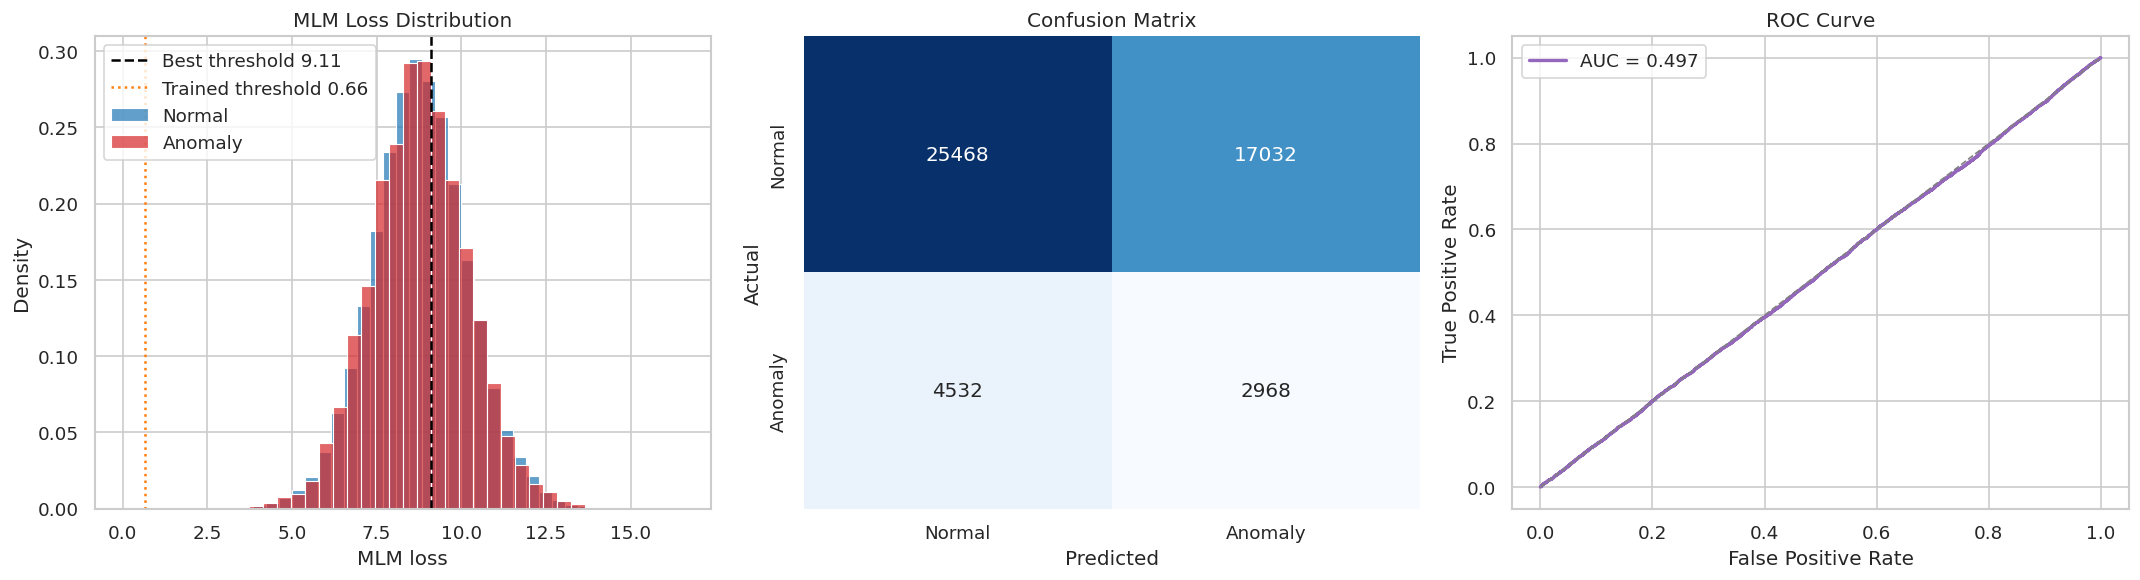

Diagnostic plot saved to ../artifacts/eval/synthetic_pipeline/diagnostics.png


In [7]:
generator = OpenStackLogGenerator(seed=SEED)
logs_df = generator.generate(total_logs=50000, anomaly_ratio=0.15)
print(f"Generated {len(logs_df):,} OpenStack logs (anomalies: {logs_df['anomaly_label'].sum():,}, ratio: {logs_df['anomaly_label'].mean():.2%})")

pipeline = SyntheticLogInferencePipeline(
    model=model,
    tokenizer=tokenizer,
    device=device,
    max_length=MAX_LENGTH,
    trained_threshold=trained_threshold,
)

result = pipeline.run(
    logs_df,
    batch_size=16,
    mask_probability=float(train_cfg["sequence"].get("mlm_probability", 0.15)),
    metric="f1",
)

print("Threshold metrics (optimal vs trained if available):")
display(result.threshold_metrics.set_index("label"))

print("Global scoring metrics:")
display(pd.DataFrame([result.global_metrics]))

artifact_dir = Path("../artifacts/eval/synthetic_pipeline")
artifact_paths = pipeline.save_artifacts(result, artifact_dir)
print("Artifacts saved:")
for name, path in artifact_paths.items():
    print(f"  - {name}: {path}")

fig = pipeline.plot_diagnostics(result)
diagnostics_path = artifact_dir / "diagnostics.png"
fig.savefig(diagnostics_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Diagnostic plot saved to {diagnostics_path}")

## Summary

- Synthetic OpenStack control-plane data generation, scoring, threshold tuning, and reporting now execute in one pipeline
- Metrics tables and ROC visual diagnostics display inline for quick validation
- Predictions, threshold sweeps, and summary metrics are exported to `../artifacts/eval/synthetic_pipeline`
- Adjust generator parameters or substitute real OpenStack log dumps to rehearse production scoring before deployment